In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import seaborn as sns
import torch

from torch import nn
from torch.utils.data import DataLoader

In [2]:
%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


torch.manual_seed(111)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### Initializing data

In [3]:
batch_size = 8
train_data_length = 2048
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] =  torch.linspace(-2*math.pi, math.pi, train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])/train_data[:, 0] - train_data[:, 0] / 10
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

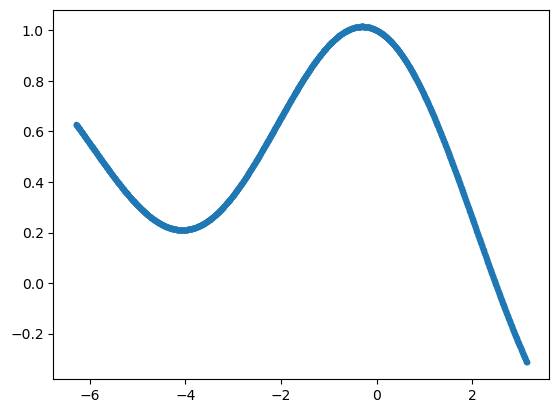

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [5]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

#### Initializing Generator, Discriminator

In [6]:
class K_Linear(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Объявляем веса как параметры слоя
        
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        nn.init.uniform_(self.weights, -0.005, 0.005)
        nn.init.uniform_(self.bias, -0.005, 0.005)
    
    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данныые
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)
    
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [K_Linear(in_feat, out_feat)] # Создаем последовательность слоев
            
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])
            
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            K_Linear(1024, 2),
#             nn.Tanh()
        )
        
    def forward(self, z):
        out = self.model(z)
        return out
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            K_Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            K_Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            K_Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        validity = self.model(x)
        return validity

#### Training GAN

In [7]:
n_epochs = 200
lr = 0.001

latent_dim = 2

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = torch.nn.BCELoss()

In [9]:
d_loss_history = []
g_loss_history = []

In [10]:
for epoch in range(n_epochs):
    for i, (real_samples, _) in enumerate(train_loader):
        
        # Лейблы для данных: 1 - настоящие, 0 - сгенерированные
        valid = torch.ones((batch_size, 1)).to(device)
        fake = torch.zeros((batch_size, 1)).to(device)
        
        # Данные для обучения дискриминатора
        real_samples = real_samples.to(device)
        # Генерация шума
        z = torch.randn((batch_size, latent_dim)).to(device)#torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        # Генерируем данные Генератором на основе шума
        generated_samples = generator(z)
        

        # ******** Обучение дискриминатора ********
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_samples)
        
        # Сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенирированые данные на Дискриминатор
        fake_pred = discriminator(generated_samples)
        
        # Рассчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # Усредняем Loss
        d_loss = (d_real_loss + d_fake_loss) / 2


        # Делаем шаг обучения Дискриминатора
        optimizer_D.zero_grad()
#         d_loss = d_loss.clamp(0, 1)
        d_loss.backward()
        optimizer_D.step()
        
        # ******** Обучение генератора ********

        # Данные для обучения генератора
        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        generated_samples = generator(z)
        
        # Подаем сгенирированые данные на Дискриминатор
        fake_pred = discriminator(generated_samples)
        
        # Сравниваем предсказанные значения Дискриминатора 
        # (на основе сгенерированных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

       
        if i % (train_data_length/batch_size) == 0:
            with torch.no_grad():
                print(f'[Epoch {epoch+1}/{n_epochs}] [Batch {i}/{len(train_loader)}]', end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')
                d_loss_history.append(d_loss.item())
                g_loss_history.append(g_loss.item())
                

[Epoch 1/200] [Batch 0/256]|[D loss: 0.6931509375572205] [G loss: 0.6929291486740112]
[Epoch 2/200] [Batch 0/256]|[D loss: 0.6604193449020386] [G loss: 0.7033904790878296]
[Epoch 3/200] [Batch 0/256]|[D loss: 0.7181180119514465] [G loss: 0.7999528646469116]
[Epoch 4/200] [Batch 0/256]|[D loss: 0.5827708840370178] [G loss: 1.3988263607025146]
[Epoch 5/200] [Batch 0/256]|[D loss: 0.7033290863037109] [G loss: 0.7898008823394775]
[Epoch 6/200] [Batch 0/256]|[D loss: 0.6358492374420166] [G loss: 0.78361976146698]
[Epoch 7/200] [Batch 0/256]|[D loss: 0.6956621408462524] [G loss: 1.8153018951416016]
[Epoch 8/200] [Batch 0/256]|[D loss: 0.7615488767623901] [G loss: 0.7089680433273315]
[Epoch 9/200] [Batch 0/256]|[D loss: 0.7712594270706177] [G loss: 0.8126747012138367]
[Epoch 10/200] [Batch 0/256]|[D loss: 0.7538408041000366] [G loss: 0.8737150430679321]
[Epoch 11/200] [Batch 0/256]|[D loss: 0.6879218816757202] [G loss: 0.972568690776825]
[Epoch 12/200] [Batch 0/256]|[D loss: 0.633072853088378

[Epoch 96/200] [Batch 0/256]|[D loss: 0.6569468975067139] [G loss: 0.6922189593315125]
[Epoch 97/200] [Batch 0/256]|[D loss: 0.6916016340255737] [G loss: 0.6737331748008728]
[Epoch 98/200] [Batch 0/256]|[D loss: 0.6840548515319824] [G loss: 0.6670387983322144]
[Epoch 99/200] [Batch 0/256]|[D loss: 0.6693253517150879] [G loss: 0.7182676792144775]
[Epoch 100/200] [Batch 0/256]|[D loss: 0.691118597984314] [G loss: 0.6928558945655823]
[Epoch 101/200] [Batch 0/256]|[D loss: 0.679081380367279] [G loss: 0.7616224884986877]
[Epoch 102/200] [Batch 0/256]|[D loss: 0.6622191667556763] [G loss: 0.7634788751602173]
[Epoch 103/200] [Batch 0/256]|[D loss: 0.6849017143249512] [G loss: 0.746799111366272]
[Epoch 104/200] [Batch 0/256]|[D loss: 0.7129777669906616] [G loss: 0.6887662410736084]
[Epoch 105/200] [Batch 0/256]|[D loss: 0.687979519367218] [G loss: 0.718698263168335]
[Epoch 106/200] [Batch 0/256]|[D loss: 0.7042034268379211] [G loss: 0.6610796451568604]
[Epoch 107/200] [Batch 0/256]|[D loss: 0.

[Epoch 190/200] [Batch 0/256]|[D loss: 0.698232889175415] [G loss: 0.694125771522522]
[Epoch 191/200] [Batch 0/256]|[D loss: 0.6944252848625183] [G loss: 0.7258612513542175]
[Epoch 192/200] [Batch 0/256]|[D loss: 0.7063121795654297] [G loss: 0.669853150844574]
[Epoch 193/200] [Batch 0/256]|[D loss: 0.6935577392578125] [G loss: 0.6892861127853394]
[Epoch 194/200] [Batch 0/256]|[D loss: 0.6970685124397278] [G loss: 0.7017241716384888]
[Epoch 195/200] [Batch 0/256]|[D loss: 0.6889066696166992] [G loss: 0.693200945854187]
[Epoch 196/200] [Batch 0/256]|[D loss: 0.6809741258621216] [G loss: 0.679703950881958]
[Epoch 197/200] [Batch 0/256]|[D loss: 0.6839885711669922] [G loss: 0.7126941084861755]
[Epoch 198/200] [Batch 0/256]|[D loss: 0.7085592746734619] [G loss: 0.6983891725540161]
[Epoch 199/200] [Batch 0/256]|[D loss: 0.6962314248085022] [G loss: 0.7250890731811523]
[Epoch 200/200] [Batch 0/256]|[D loss: 0.6859075427055359] [G loss: 0.7275358438491821]


#### Changing in binary cross-entropy from epochs

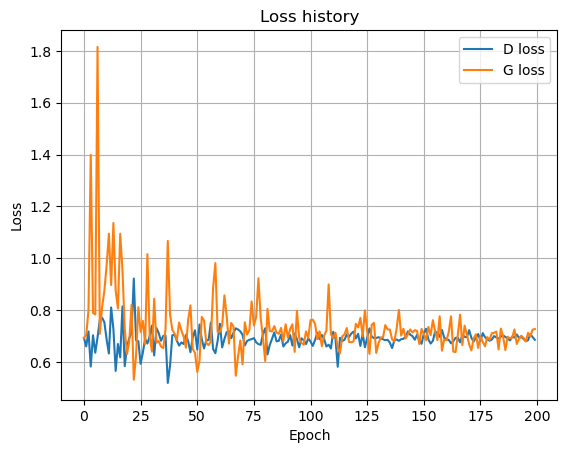

In [11]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(np.array(d_loss_history), label='D loss')
plt.plot(np.array(g_loss_history), label='G loss')
plt.legend()
plt.show()

#### The result of GAN work
Построим сгенерированные данные и проверим, насколько они похожи на обучающие данные.

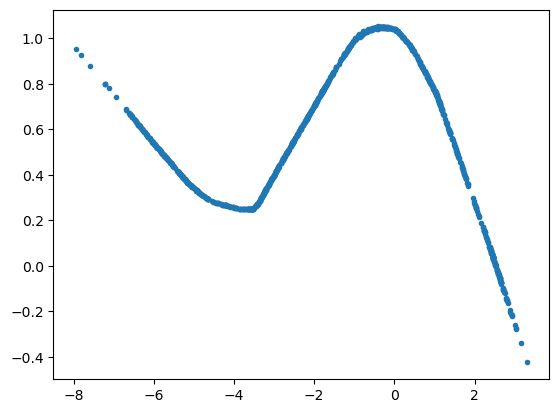

In [12]:
space_samples = torch.randn(1024, latent_dim).to(device)
generated_samples = generator(space_samples)


generated_samples = generated_samples.detach().cpu()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

#### Source data

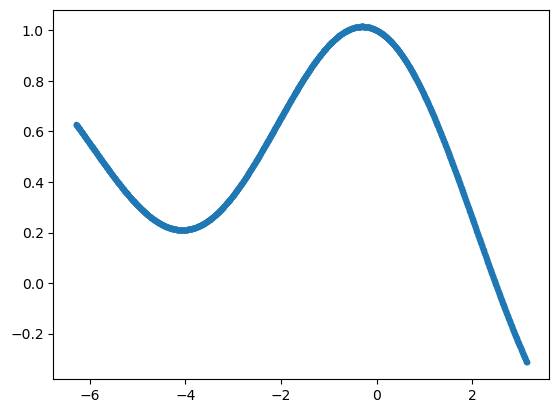

In [13]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")